<a href="https://colab.research.google.com/github/Basel-byte/Network-Anomaly-Detection/blob/new-clustering-algorithm/Pr_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice Lab: Clustering  

In this exercise, we will know how K-Means and Normalized Cut algorithms can be used for network anomaly detection.

# Outline
- [ 1 - Extracting Dataset](#1)
- [ 2 - Packages ](#2)
- [ 3 - Reading data and Preprocessing](#3)
  - [3.1 Reading Columns' Names](#3.1)
  - [3.2 Reading dataset](#3.2)
  - [3.3 Removing class column](#3.3)
  - [3.4 Changing Categorical features to numericals](#3.4)
  
   
- [ 4 - K-means](#4)
- [ 5 - Spectral Clustering](#5)
- [ 6 - New Clustering Algorithm](#6)
- [ 7 - Clustering Evaluation](#7)

  

<a name="1"></a>
## 1 - Extracting Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# do not run if you have unzipped the dataset
!gzip -d /content/drive/MyDrive/kddcup.data.gz

gzip: /content/drive/MyDrive/kddcup.data.gz: No such file or directory


<a name="2"></a>
## 2 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
<!-- - [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python. -->
<!-- - [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning. -->
- [pandas](https://pandas.pydata.org/) is open source data analysis and manipulation tool.

In [4]:
import numpy as np
import pandas as pd
import os
import requests
from enum import Enum
import re
from scipy.spatial import KDTree
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import mode

<a name="3"></a>
## 3 - Reading data and Preprocessing

<a name="3.1"></a>
#### Reading columns' names 

In [5]:
DATASET_COLUMNS_FILE = "/content/drive/MyDrive/kddcup1999_columns.txt"
column_types =[]

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[:]:
    match = column_regex.match(column_type)
    column_types.append(match.group("column_name"))


<a name="3.2"></a>
#### reading the dataset

In [6]:
data = pd.read_csv("/content/drive/MyDrive/kddcup.data", header=None)
data.columns = column_types

<a name="3.3"></a>
#### Removing class column

In [7]:
data_without_labels = data.drop(columns=["class"])
labels = data["class"]
del data
del column_types
data_without_labels

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,3,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,4,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,5,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0


<a name="3.4"></a>
### Change the categorical features to numericals

In [24]:
def convert_string_to_numeric(data_frame):
  # df_copy = data_frame.copy()
  my_dict = None
  for col in data_frame:
    if data_frame[col].dtypes == object:
      my_dict = {elem: index for index, elem in enumerate(data_frame[col].unique())}
      data_frame[col].replace(my_dict, inplace=True)
  return data_frame, my_dict

In [9]:
def convert_string_to_binary_numeric(data_frame):
  # df_copy = data_frame.copy()
  for col in data_frame:
    if data_frame[col].dtypes == object:
      df1 = pd.get_dummies(data_frame[col])
      data_frame = pd.concat([data_frame, df1], axis=1).reindex(data_frame.index)
      data_frame.drop(col, axis=1, inplace=True)
  return data_frame

In [10]:
# use either of them but not both
# convert_string_to_numeric(data_without_labels.copy())

data_without_labels = convert_string_to_binary_numeric(data_without_labels)

<a name="3"></a>
## 3 - K-means



In [11]:
def Kmeans(data_frame_no_label, k = 3):
  return 0

<a name="4"></a>
## 4 - Spectral clustering


In [12]:
def spectral_clustering(data_frame_no_label, k = 3):
  return 0

<a name="5"></a> 
## 5-  New Clustering Algorithm (Density-Based Spatial Clustering for Applications with Noise (DBSCAN))

In [13]:
def nearby_points_indices(D, point, epsilon, tree):
  nearby_points_indices = tree.query_ball_point(point, epsilon)
  return nearby_points_indices


In [14]:
def DBSCAN(D, epsilon, min_points=4):
  tree = KDTree(D)
  clusters = 0
  assignments = np.zeros(D.shape[0], dtype=np.int32)
  visited = [False] * D.shape[0]
  for i in range(D.shape[0]):
    if not visited[i]:
      visited[i] = True
      neighbor_indices = nearby_points_indices(D, D[i], epsilon, tree)
      if len(neighbor_indices) > min_points:
        clusters += 1
        D[i] = clusters
        expand_cluster(D, D[i], neighbor_indices, clusters, visited, assignments, tree, epsilon, min_points)
  return assignments

In [15]:
def expand_cluster(D, point, neighbor_indices, clusters, visited, assignments, tree, epsilon, min_points):
  for neighbor_index in neighbor_indices:
    if not visited[neighbor_index]:
      visited[neighbor_index] = True
      neighbors_of_neighbor = nearby_points_indices(D, D[neighbor_index], epsilon, tree) 
      if len(neighbors_of_neighbor) > min_points:
        neighbor_indices.extend(neighbors_of_neighbor)
    if assignments[neighbor_index] == 0:
      assignments[neighbor_index] = clusters



### Plotting K-nearest distance graph to compute the best value for epsilon 

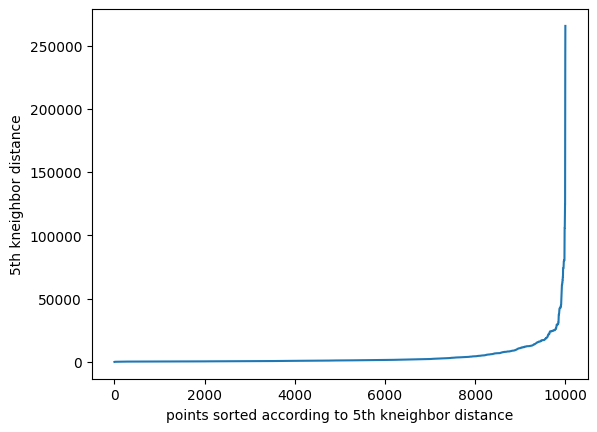

1827.276545457999

In [16]:
slice = 10000
data = np.array(data_without_labels[:slice])
distances = pairwise_distances(data)
k_nearest_distances = distances[:, 4]
k_nearest_distances = np.sort(k_nearest_distances)
x = np.arange(0, slice);
plt.plot(x, k_nearest_distances)
plt.xlabel("points sorted according to 5th kneighbor distance")
plt.ylabel("5th kneighbor distance")
plt.show()
np.average(k_nearest_distances[:9000])

In [20]:
def measure_precision(real_labels, predicted_labels, dict):
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    print(f'major anomaly in this cluster is {dict.get(major_class.mode[0])} with ratio {major_class.count[0] / cluster.size}')
    sum += major_class.count[0] / cluster.size
  return sum / unique_predic.size

In [17]:
def measure_f1(real_labels, predicted_labels,counts):
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  #print(unique_predic)
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    #print(major_class.count[0] / cluster.size, ", ", major_class.count[0] / counts[major_class.mode[0]])
    recall = major_class.count[0] / counts[major_class.mode[0]]
    precis = major_class.count[0] / cluster.size
    sum += (2 * recall * precis) / (recall + precis)
  return sum / unique_predic.size

In [25]:
labels_m = train_test_split(labels, train_size=0.0015, random_state=42, stratify=labels)[0]
data_m = train_test_split(data_without_labels, train_size=0.0015, random_state=42, stratify=labels)[0]
labels_m, dict = convert_string_to_numeric(pd.DataFrame(labels_m))
labels_m = labels_m.values
labels_m = labels_m.reshape(labels_m.size)
counts = np.unique(labels_m, return_counts=True)[1]
dict = {value: key for key, value in dict.items()}
pred_labels = DBSCAN(np.array(data_m), epsilon=100, min_points=5)
f = measure_f1(labels_m, pred_labels, counts)
prec = measure_precision(labels_m, pred_labels, dict)
print("f-score =", f)
print("precision =",prec)

major anomaly in this cluster is normal. with ratio 0.9512195121951219
major anomaly in this cluster is neptune. with ratio 0.807035175879397
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is smurf. with ratio 1.0
major anomaly in this cluster is smurf. with ratio 0.9987029831387808
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is satan. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
major anomaly in this cluster is normal. with ratio 1.0
f-scor

In [ ]:
def find_best_epsilon(data, labels):
  epsion = 100
  max_f1_score = 0
  for e in range(100, 2000, 100):
    pred_labels = DBSCAN(data, epsilon=e, min_points=5)
    f1 = measure_f1(labels, pred_labels, counts)
    if f1 > max_f1_score:
      max_f1_score = f1
      epsilon = e
  return epsion

epsion = find_best_epsilon(np.array(data_m), labels_m)
print(epsion)

In [ ]:
# points = [[0, 0], [0, 1], [0, 2], [0, 3]]
# tree = KDTree(points)
# neighbor_indices = nearby_points_indices(np.array(points), points[0], 0, tree)
# neighbor_indices
# print(DBSCAN(np.array(points), 1, 2))

<a name="6"></a>
## 6- Clustering Evaluation